<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/notebooks/es11/AML_2022_HandsOn_11_Normalizing_flow_realNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#run this if first time!
!pip install --upgrade git+https://github.com/VincentStimper/normalizing-flows.git
#!git clone https://github.com/VincentStimper/normalizing-flows.git
#!pip install -r normalizing-flows/requirements_examples.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-lsi98gwj
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-lsi98gwj
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-ek5lpzmr/residual-flows_6c71e3aad6e14efba391b169a3d70b5b
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-ek5lpzmr/residual-flows_6c71e3aad6e14efba391b169a3d70b5b


In [ ]:
# Import required packages
import torch
from torch import nn
import numpy as np
import normflow as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

# A "related" example : Generating exponential distributed numbers with an uniform generator

Lets say that we want to generate numbers with an exponential distribution. The pdf is

$$ f(x) = \begin{Bmatrix}
 \lambda e^{-\lambda x},& x>=0  \\
 0,&   x<0\\
\end{Bmatrix} $$

And the cdf is

$$F(x) = \int_{-\inf}^{x} f(t)dt =  \begin{Bmatrix}
 1- \lambda e^{-\lambda x},& x>=0  \\
 0,&   x<0\\
\end{Bmatrix}$$

If we can generate numbers with a uniform distribution (calling the function rand  for example) we can then:
- Compute the cdf of the desired random variable
- Set $R = F(X)$ on the range of $X$ (For the exponential distribution, $ R = 1 - e^{-\lambda x} $ on the range of $x \ge 0$. )
- Solve the equation F(X) = R for $X$ in terms of $R$. 

For the exponential distribution above we have

$$ X = \frac{-1}{\lambda} \ln(1-R)$$

We can try in a few lines of code below.

This is an easy case  but once we have this procedure established, we can proceed to solve other similar distribution for which a inverse function is relatively easy to obtain and has a closed formula. 

**Unfortunately, the vast majority of interesting distributions cannot be inverted**

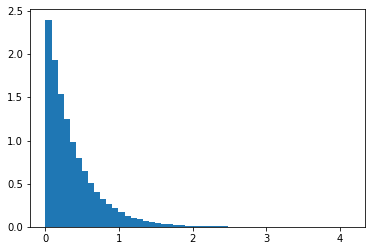

In [ ]:
# We can try in a few lines of code
def ExpPowerFun(l, size=1000):
    x = np.random.rand(size)
    return np.log(1-x)*(-1.0/l)

import matplotlib.pyplot as plt
plt.hist(ExpPowerFun(2.7,100000),50,density=True)
plt.show()


Details of this explanation can be found here: https://arxiv.org/pdf/1410.8516.pdf

# First ingredient - the Flow
A flow model is a probability distribution $q$ defined as the pushforward of an analytically tractable base distribution $p$ through a flexible diffeomorphism $f$

 Independent samples from $q$ can be generated in parallel, by first sampling z from $p$ and taking $x = f(z)$. The probability density of a sample can be obtained using a change of variables, 

$$ q(x) = p(z)|det J_f (z)|$$



[direct inverse](https://drive.google.com/uc?id=1CDwhHNrfaKBoBvhinGDIWm-b4oNj_TNg)



The key novelty of the  approach that we are going to describe is the design of such a transformation $f$  that has two properties:
- It has an determinant that is easy to compute.
- It is easy to invert. 

Computing the Jacobians and the determinants of high dimensional functions can be very difficult so we will apply a trick by design a class of transformation that can be easily treated by exploiting the property of triangular matrices for which the determinants is just the product of the diagonal terms.

Also, since a sequence of invertible functions is also invertible, we will compose our complex transform with a sequence of simpler transformation of this kind. We will call these function the elements of the flow.

For the two dimensional case a transformation of the flow can be written as (cfr. eq. 4 and 5 of the parer for the general case):
$$ y_1 = x_1$$
$$ y_2 = x_2 e^{s(x_1)} + t(x_1)$$

where $t,s$ are two differentiable function 

The elements of the jacobian $J_{i,j}$ for this transformation are:
$$J_{i,j}=\frac{\partial y_i}{\partial x_j} = \begin{Bmatrix}
1, & i,j = 1,1  \\
0 ,& i,j = 1,2 \\
 x_2 s'(x_1)e^{s(x_1)}+t'(x_1),& i,j = 2,1  \\
e^{s(x_1)} ,& i,j = 2,2 \\
\end{Bmatrix}$$

This transformation can be easily inverted with:


$$ x_1 = y_1$$
$$ x_2 =( y_2- t(y_1) ) e^{-s(y_1)} $$

Let's focus on $t$ and $s$:
- To compute the Jacobian they only need to be differentiable.
- To compute the inverse transformation we do not need to compute the inverse of $t$ and $s$.

So they can both be arbitrary complex and difficult to be inverted.

The problem now is to find the correct flow, so the set of K function $t$ and $s$ that can generate the transformation that we want.

In this notebook we will work with a routine that will approximate the transformation $f$ (so the set of t and s) with a neural network.


## This is a basic element of the Flow
- The input are the variables to be transformed (the original ones or the one from the previous transformation)
- The outputs are the transformed variable and the log of the absolute determinant of the jacobian (that for this class of transformations is the product of the diagonal)
- We will also need to compute algebrically the inverse of the transformation. 

These elements of the flow $f = f_K \circ ... \circ f_2 \circ f_1$ will compose the transformation and the Jacobian determinant of the total transformation will be the product of the elements' Jacobian determinant.

To make sure that the determinant is easy to compute each  matrix will be triangular as described above.



In [ ]:
class Flow(nn.Module):
    """
    Generic class for flow functions
    """
    def __init__(self):
        super().__init__()

    def forward(self, z):
        """
        :param z: input variable, first dimension is batch dim
        :return: transformed z and log of absolute determinant (that is the product of the diagonal terms)
        """
        raise NotImplementedError('Forward pass has not been implemented.')

    def inverse(self, z):
        raise NotImplementedError('This flow has no algebraic inverse.')

## This is the Flow implementation for the Real NVP

Now that the basic idea is clear we can focus on the paper implementation. See https://arxiv.org/abs/1605.08803 for detatils.

- The transformation depends on a scale function $s$ and a translation function $t$. We will use  two neural networks as t and s.
- For each element of the flow the s and t are different. There will be a set of K $ \{t_i,s_i\} $.
- In this case there is also a mask that apply the transformation only on a subset of the variables (as described in the paper).

This transformation will be called forward:

$$ y_1 = x_1$$
$$ y_2 = x_2 e^{s(x_1)} + t(x_1)$$

This transformation will be called inverse:


$$ x_1 = y_1$$
$$ x_2 =( y_2- t(y_1) ) e^{-s(y_1)} $$

**notice how s and t are the same for both the direct and the inverse transformation**

For the direct transformation the jacobian is:

$$J=\bigl(\begin{matrix}
 1&0  \\
\frac{\partial y_2}{\partial x_1} &  e^{s(x_1)}\\
\end{matrix}\bigr)$$

In [ ]:
class MaskedAffineFlow(Flow):
    """
    RealNVP as introduced in arXiv: 1605.08803
    Masked affine flow f(z) = b * z + (1 - b) * (z * exp(s(b * z)) + t)
    class AffineHalfFlow(Flow): is MaskedAffineFlow with alternating bit mask
    NICE is AffineFlow with only shifts (volume preserving)
    """

    def __init__(self, b, t, s):
        """
        Constructor
        :param b: mask for features, i.e. tensor of same size as latent data point filled with 0s and 1s

        :param t: translation mapping, i.e. neural network, where first input dimension is batch dim,
    
        :param s: scale mapping, i.e. neural network, where first input dimension is batch dim,
       
        """
        super().__init__()
        self.b_cpu = b.view(1, *b.size())
        self.register_buffer('b', self.b_cpu)

        self.add_module('s', s)# s will be a neural network and the transformation will depends on its weigths 

        self.add_module('t', t)# t will be a neural network and the transformation will depends on its weigths 


    def forward(self, z):
        z_masked = self.b * z
        scale = self.s(z_masked)# this is s(x)
        nan = torch.tensor(np.nan, dtype=z.dtype, device=z.device)
        scale = torch.where(torch.isfinite(scale), scale, nan)# regularization. We put nan when the transformation is infinite
        trans = self.t(z_masked)# this is t(x)
        trans = torch.where(torch.isfinite(trans), trans, nan)
        z_ = z_masked + (1 - self.b) * (z * torch.exp(scale) + trans) # direct transform
        log_det = torch.sum((1 - self.b) * scale, dim=list(range(1, self.b.dim()))) # this is the logaritm of the determinant. Since this term is exp(s) the log is just the scale function
        return z_, log_det

    def inverse(self, z):# analitical inverse
        z_masked = self.b * z
        scale = self.s(z_masked)
        nan = torch.tensor(np.nan, dtype=z.dtype, device=z.device)
        scale = torch.where(torch.isfinite(scale), scale, nan)
        trans = self.t(z_masked)
        trans = torch.where(torch.isfinite(trans), trans, nan)
        z_ = z_masked + (1 - self.b) * (z - trans) * torch.exp(-scale)
        log_det = -torch.sum((1 - self.b) * scale, dim=list(range(1, self.b.dim())))
        return z_, log_det

## This is the batch normalization for the Flow as described in the paper 
This is the proposed generalization of batch normalization for the flow transformation. It is a invertible function in which s and t are constant and computed on batch statistics.

In [ ]:
class ActNorm(Flow):
    """
    scales and shifts with learned constants per dimension. 
    """

    def __init__(self, shape):
        """
        Constructor
        :param shape: Shape of the coupling layer
  
        """
        super().__init__()
        
        self.s = nn.Parameter(torch.zeros(shape)[None]) # this is the shift function
        
        
        self.t = nn.Parameter(torch.zeros(shape)[None]) # this is the scale function
        
        self.n_dim = self.s.dim()
        self.batch_dims = torch.nonzero(torch.tensor(self.s.shape) == 1, as_tuple=False)[:, 0].tolist()
        self.data_dep_init_done_cpu = torch.tensor(0.)
        self.register_buffer('data_dep_init_done', self.data_dep_init_done_cpu)

    def forward(self, z):
        
         # first batch is used for initialization, c.f. batchnorm
        if not self.data_dep_init_done > 0.:
            assert self.s is not None and self.t is not None
            s_init = -torch.log(z.std(dim=self.batch_dims, keepdim=True) + 1e-6)
            self.s.data = s_init.data
            self.t.data = (-z.mean(dim=self.batch_dims, keepdim=True) * torch.exp(self.s)).data
            self.data_dep_init_done = torch.tensor(1.)
        
        z_ = z * torch.exp(self.s) + self.t
        if len(self.batch_dims) > 1:
            prod_batch_dims = np.prod([z.size(i) for i in self.batch_dims[1:]])
        else:
            prod_batch_dims = 1
        log_det = prod_batch_dims * torch.sum(self.s)
        return z_, log_det

    def inverse(self, z):
        
         # first batch is used for initialization, c.f. batchnorm
        if not self.data_dep_init_done:
            assert self.s is not None and self.t is not None
            s_init = torch.log(z.std(dim=self.batch_dims, keepdim=True) + 1e-6)
            self.s.data = s_init.data
            self.t.data = z.mean(dim=self.batch_dims, keepdim=True).data
            self.data_dep_init_done = torch.tensor(1.)
        
        
        z_ = (z - self.t) * torch.exp(-self.s)
        if len(self.batch_dims) > 1:
            prod_batch_dims = np.prod([z.size(i) for i in self.batch_dims[1:]])
        else:
            prod_batch_dims = 1
        log_det = -prod_batch_dims * torch.sum(self.s)
        return z_, log_det


## Definition of the t and s function.
We want that our model is able to learn the t and s fuction. 
- t and s can be anything and the only need to be differenziable so we will use a MLP (any architecture can be used)
- The transformation that are based on s and t depends on the parameters of theese network. 
- Training in this case means finding the paramenters of t and s.

In [ ]:
class MLP(nn.Module):
    """
    A multilayer perceptron with Leaky ReLU nonlinearities
    """

    def __init__(self, layers, leaky=0.0, output_fn=None, init_zeros=False, dropout=None):
       
        super().__init__()
        net = nn.ModuleList([])
        for k in range(len(layers)-2):
            net.append(nn.Linear(layers[k], layers[k+1]))
            net.append(nn.LeakyReLU(leaky))
        if dropout is not None:
            net.append(nn.Dropout(p=dropout))
        net.append(nn.Linear(layers[-2], layers[-1]))
        if init_zeros:
            nn.init.zeros_(net[-1].weight)
            nn.init.zeros_(net[-1].bias)
        if output_fn is not None:
           
            if output_fn == "sigmoid":
                net.append(nn.Sigmoid())
            elif output_fn == "relu":
                net.append(nn.ReLU())
            elif output_fn == "tanh":
                net.append(nn.Tanh())
            else:
                NotImplementedError("This output function is not implemented.")
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

## Flow definition.
- We will define $K$ transformations (followed by a batch normalization) that will be concatenated to form the final model.
- Notice how we instantiate s and t at every step so they are independet networks.
- The mask will be inverted at each step

Remember that $$det(AB)=det(A)det(B)$$ so 
$$log(det(AB))=log(det(A)) + log(det(B))$$

In [ ]:
# Set up the flow

# Define flows
K = 32 # number of transformation if the flow
torch.manual_seed(0)

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []# here we will put the "flow" of the simple invertible transformations
for i in range(K):
    s = MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True, output_fn=None)# this is just a 3 layer MLP. Only input and output must be equal to the latent size. Hidden layer can be of any size
    t = MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True, output_fn=None)
    if i % 2 == 0:
        flows += [MaskedAffineFlow(b, t, s)]
    else:
        flows += [MaskedAffineFlow(1 - b, t, s)]
    flows += [ActNorm(latent_size)]

# Set prior and q0
prior = nf.distributions.TwoModes(2, 0.1)# this is the "target distribution" (for example an image or a complex dataset)
q0 = nf.distributions.DiagGaussian(2)# this is the simple distribution that we can easily sample

## Finally the model definition.
Here is the model. We need:
-  A function that sample from the model sample(self, num_samples=1)
  - First we sample the "starting" probability distribution
  - Then we will apply the flow of transformation to obtain the probability distribution approximated by the model

- A function to compute the KL Divergence to be used as loss.

Notice how we can train the whole model (both the direct and inverse transformation) by optimiziong only one direction.

This is possible because both the encoding and decoding depends on the same functions and the inverse is analically computed.

In [ ]:
def set_requires_grad(module, flag):# help function for learnable parameters
    """
    Sets requires_grad flag of all parameters of a torch.nn.module
    :param module: torch.nn.module
    :param flag: Flag to set requires_grad to
    """

    for param in module.parameters():
        param.requires_grad = flag


class NormalizingFlow(nn.Module):
    """
    Normalizing Flow model to approximate target distribution
    """
    def __init__(self, q0, flows, p=None):
        """
        Constructor
        :param q0: Base distribution
        :param flows: List of flows
        :param p: Target distribution
        """
        super().__init__()
        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p
    def forward_kld(self, x):
        """
        Estimates forward KL divergence, see arXiv 1912.02762
        :param x: Batch sampled from target distribution
        :return: Estimate of forward KL divergence averaged over batch
        """
        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return -torch.mean(log_q)


    def reverse_kld(self, num_samples=1, beta=1.):
        """
        Estimates reverse KL divergence, see arXiv 1912.02762
        :param num_samples: Number of samples to draw from base distribution
        :param beta: Annealing parameter, see arXiv 1505.05770
        :return: Estimate of the reverse KL divergence averaged over latent samples
        """
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z) # chain of transformations (direct)
            log_q -= log_det
        
        log_p = self.p.log_prob(z) # z match the prior? (this function contain the set of inverse transformations)
        return torch.mean(log_q) - beta * torch.mean(log_p) #this is <log p(x) - log q(x)> averaged over the sampled values 


    def sample(self, num_samples=1):
        """
        Samples from flow-based approximate distribution
        :param num_samples: Number of samples to draw
        :return: Samples, log probability
        """
        z, log_q = self.q0(num_samples)# a sample from the gaussian distribution
        for flow in self.flows:
            z, log_det = flow(z)# transformation applied in sequence
            log_q -= log_det # this is the sum of log determinant 
        return z, log_q

    def log_prob(self, x):
        """
        Get log probability for batch
        :param x: Batch
        :return: log probability
        """
        log_q = torch.zeros(len(x), dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z) # inverse transformation flow
            log_q += log_det
        log_q += self.q0.log_prob(z)
        return log_q

    def save(self, path):
        """
        Save state dict of model
        :param path: Path including filename where to save model
        """
        torch.save(self.state_dict(), path)

    def load(self, path):
        """
        Load model from state dict
        :param path: Path including filename where to load model from
        """
        self.load_state_dict(torch.load(path))

## This is the output of the network before training. The transformation is initialized as an identity

out shape:  (131072, 2)


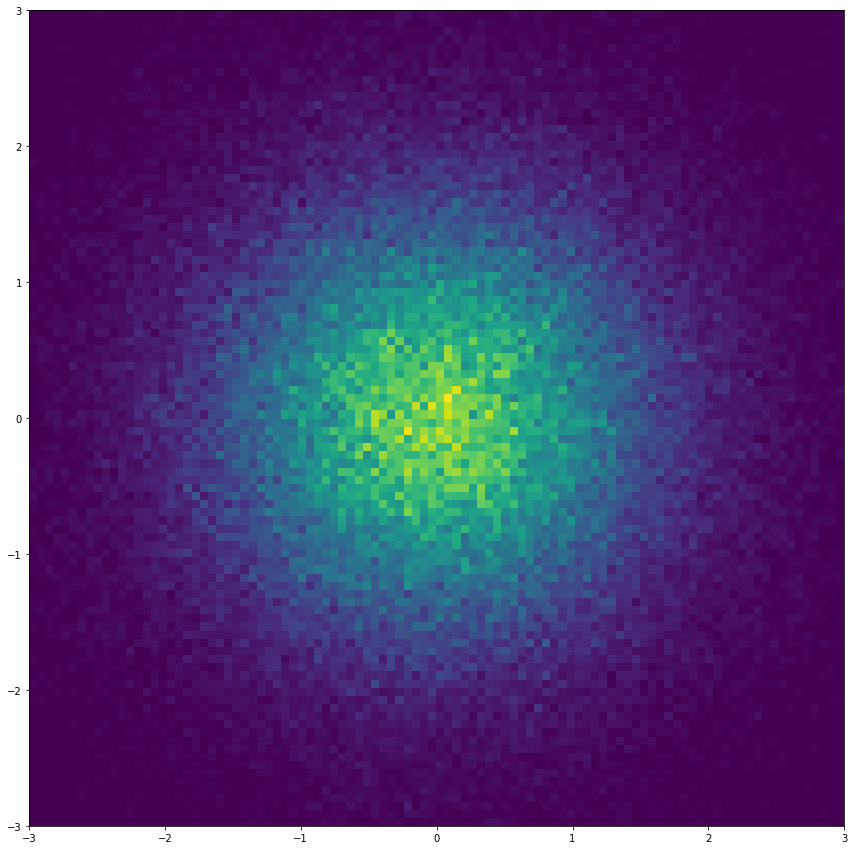

In [ ]:
# Construct flow model
nfm = NormalizingFlow(q0=q0, flows=flows, p=prior)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

# Initialize ActNorm
z, _ = nfm.sample(num_samples=2 ** 17)
z_np = z.to('cpu').data.numpy()
print("out shape: ",z_np.shape)
plt.figure(figsize=(15, 15))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (100, 100), range=[[-3, 3], [-3, 3]])#first two dimention of the gaussian ball
plt.gca().set_aspect('equal', 'box')
plt.show()

## The continuos lines are the distribution of the target. We want that our network otput matches the target after training. 

In [ ]:
# Plot prior distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = prior.log_prob(zz).to('cpu').view(*xx.shape)
prob_prior = torch.exp(log_prob)

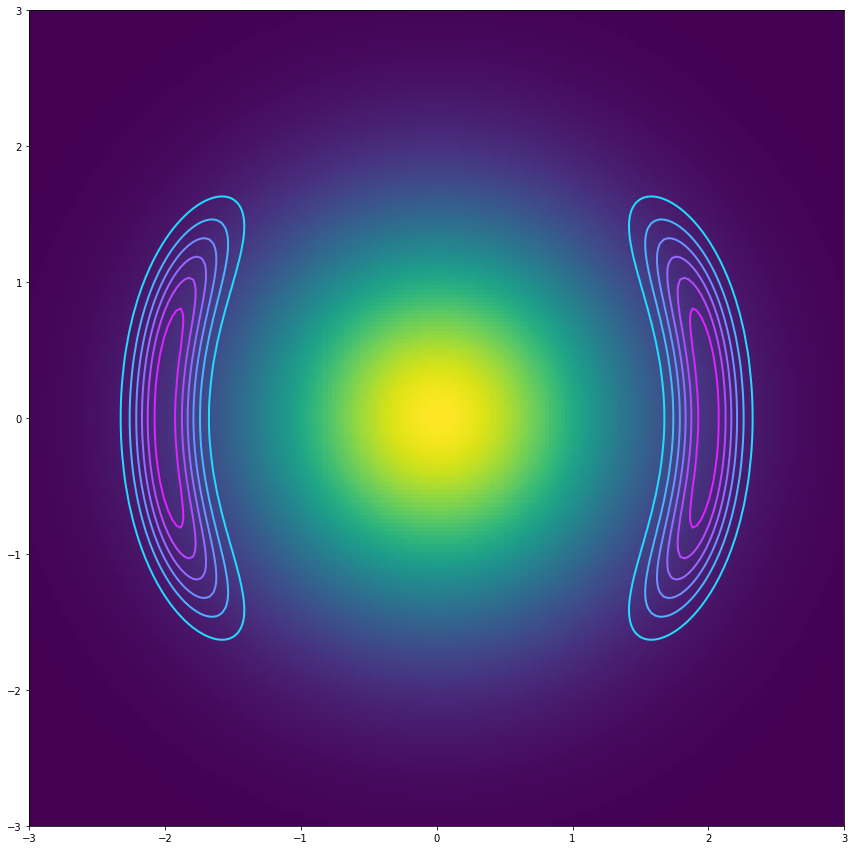

In [ ]:
# Plot initial posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

  1%|          | 100/15000 [00:05<25:14,  9.84it/s]

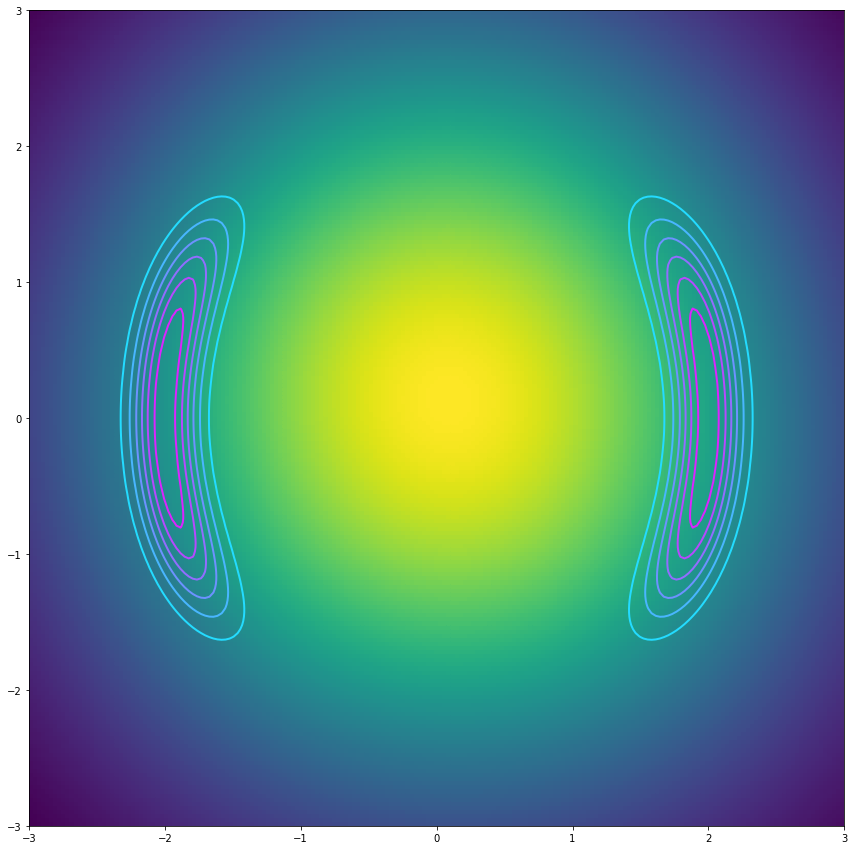

 33%|███▎      | 4999/15000 [03:57<07:20, 22.69it/s]

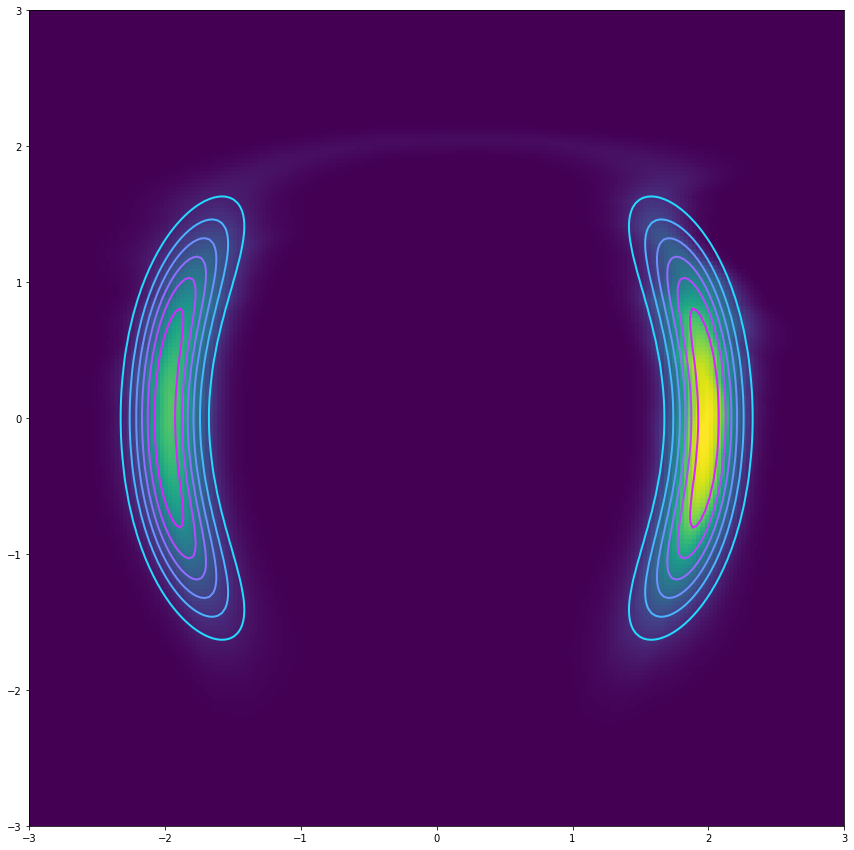

 67%|██████▋   | 9997/15000 [07:41<04:04, 20.45it/s]

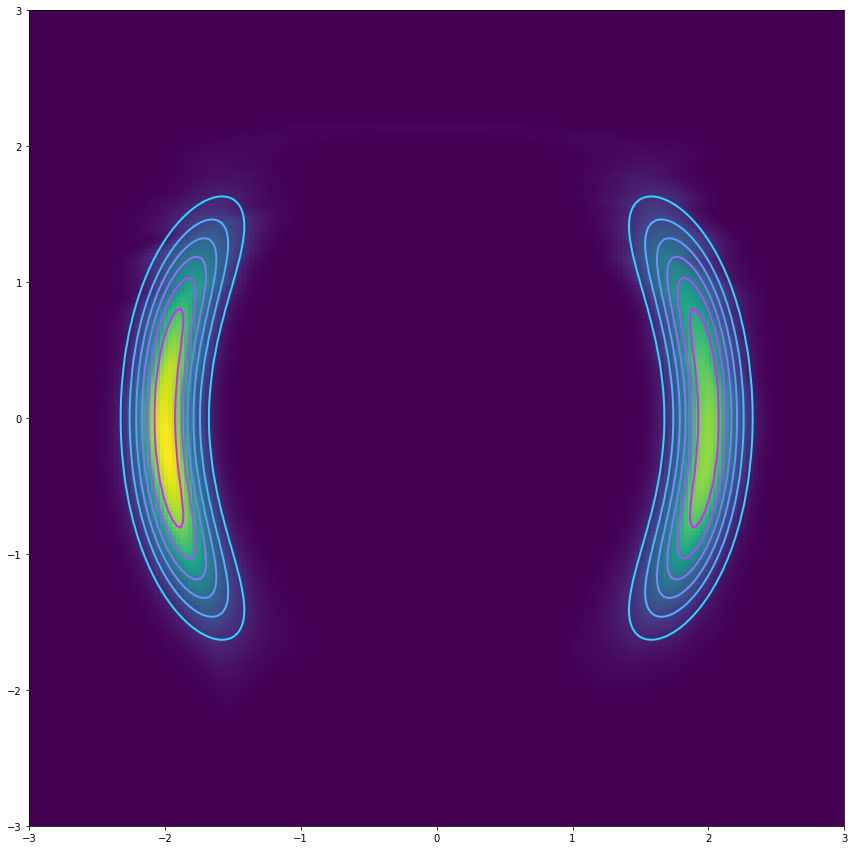

100%|█████████▉| 14997/15000 [11:23<00:00, 22.05it/s]

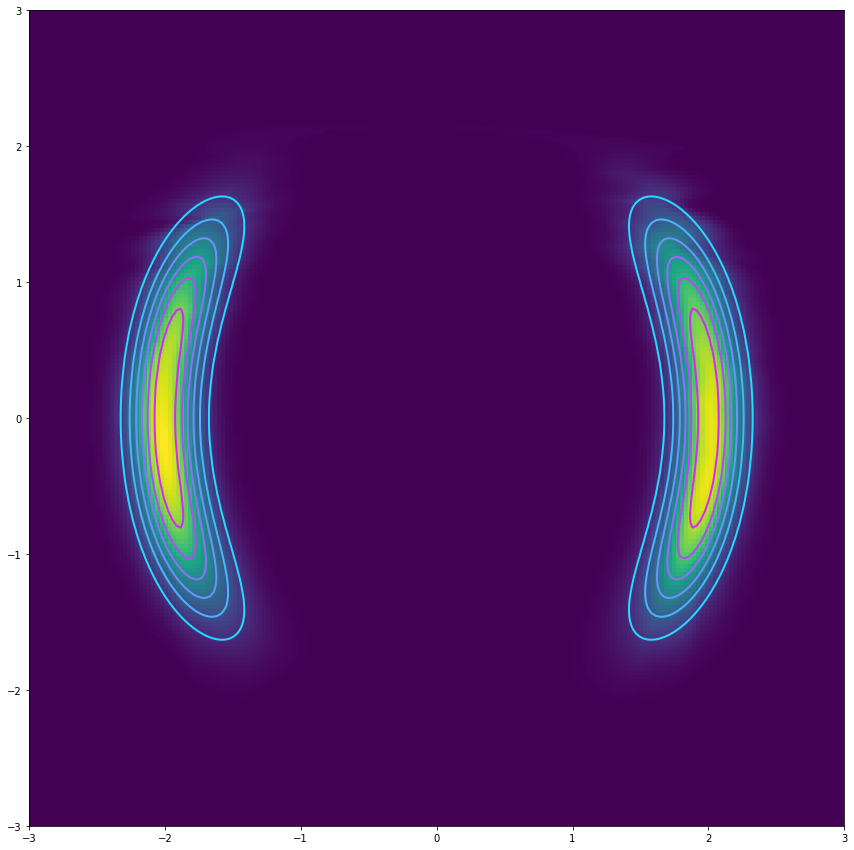

100%|██████████| 15000/15000 [11:24<00:00, 21.92it/s]


In [ ]:
# Train model
max_iter = 15000
num_samples = 256
anneal_iter = 5000

show_iter = 5000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=3e-4, weight_decay=1e-6)
for it in tqdm(range(max_iter)):# tqdm is the progress bar
    optimizer.zero_grad()
    
    loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.001 + it / anneal_iter])) # loss when we can compute the log prob for the target distribution (also numerically)
    #loss  =  nfm.forward_kld(batch_of_elements_sampled_from_target_distribution) # Alternative loss if we can sample (for example with MC) from the target distribution
   
    
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if ((((it + 1) % show_iter) == 0) | (it == 100)) :
        log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.show()

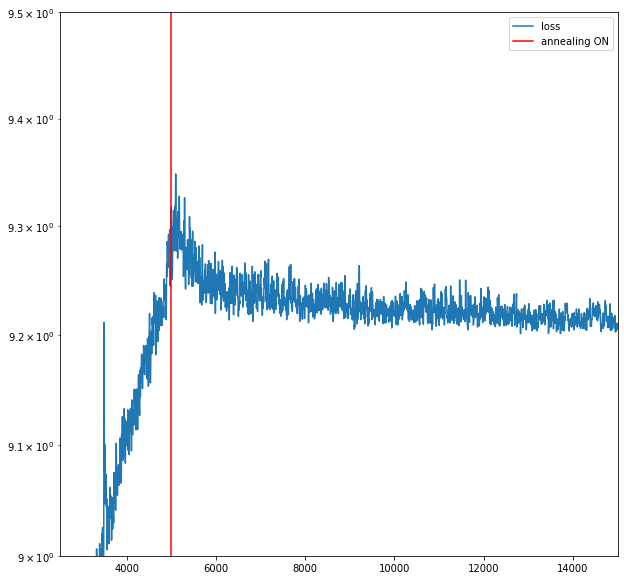

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

loss_hist = gaussian_filter1d(loss_hist, sigma=3)# a bit of smoothing for the loss

plt.figure(figsize=(10, 10))
plt.plot(loss_hist+10, label='loss')

plt.xlim([2500,max_iter])
plt.yscale('log')
plt.ylim(9,9.5)
plt.axvline(5000,label="annealing ON",color="r")
plt.legend()
plt.show()


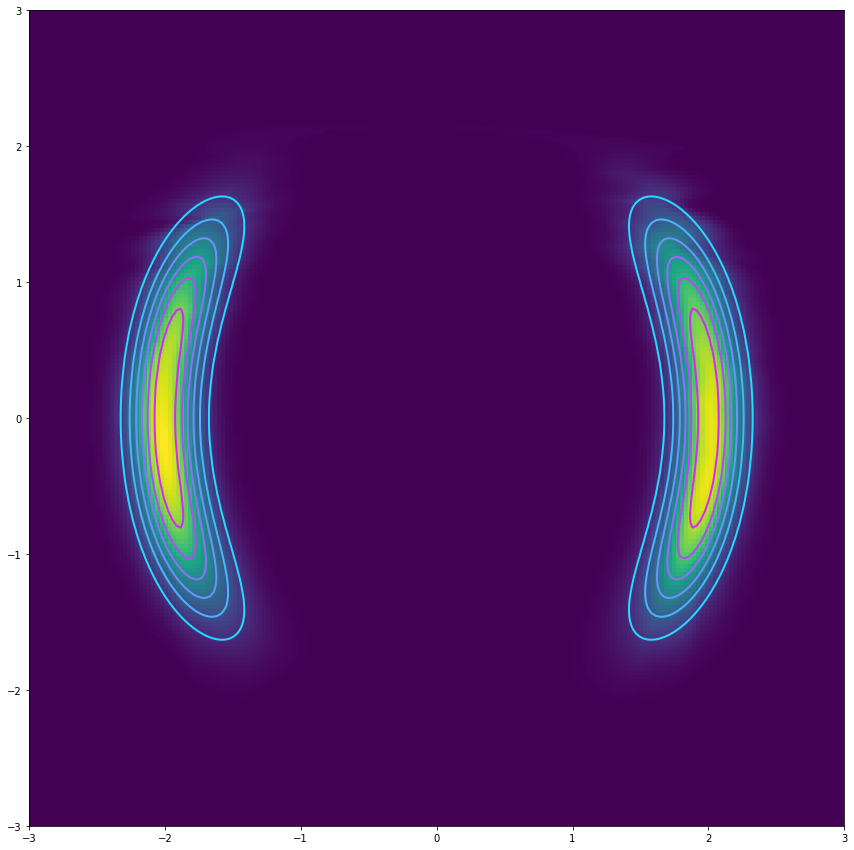

In [ ]:
# Plot learned posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

# This is the output after training.
If we sample from a 2D gaussian distribution we can transform the input and obtain numbers sampled from a distribution that aproximates the target ones.

out shape:  (131072, 2)


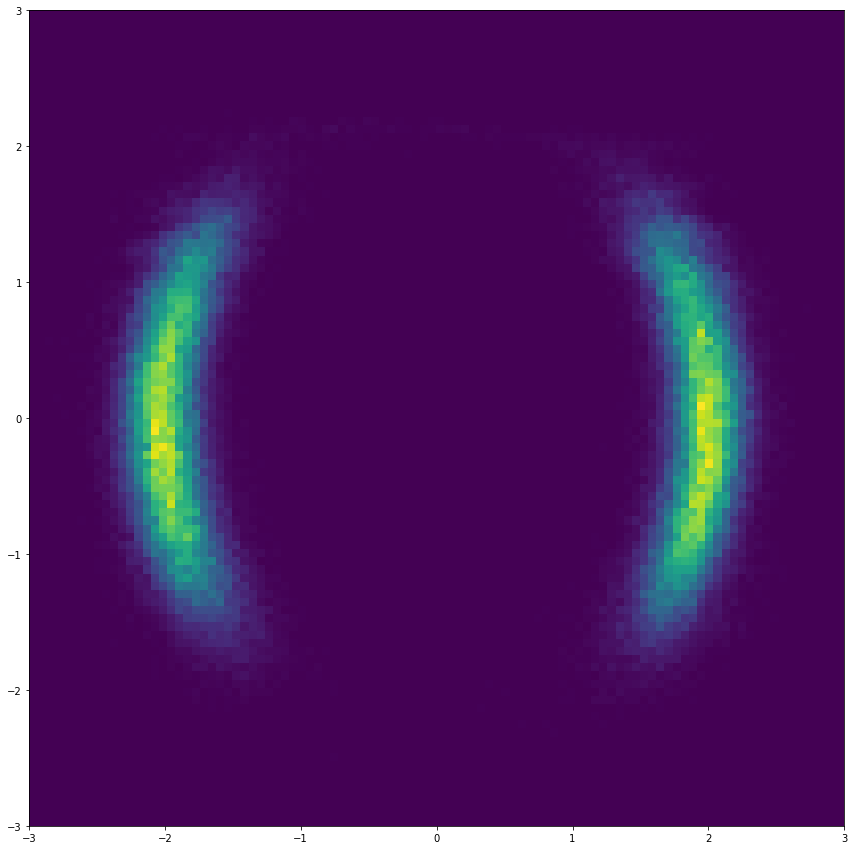

In [ ]:
# Initialize ActNorm
z, _ = nfm.sample(num_samples=2 ** 17)
z_np = z.to('cpu').data.numpy()
print("out shape: ",z_np.shape)
plt.figure(figsize=(15, 15))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (100, 100), range=[[-3, 3], [-3, 3]])#first two dimention of the gaussian ball
plt.gca().set_aspect('equal', 'box')
plt.show()